# simple implementation of a french pos tagger 
three-word sequence with word embedding
naive network

In [1]:
import re
from collections import Counter
import numpy as np
import theanets
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix
from pandas_ml import ConfusionMatrix




#get train and test data from french universal dependency Sequoia Treebank
train_f = open('fr_sequoia-ud-train.conllu')
test_f = open('fr_sequoia-ud-test.conllu')
train_data = train_f.readlines()
test_data = test_f.readlines()
train_f.close()
test_f.close()

#extract pairs of word and pos from each phrase in UD 
#input: file content of UD (a list containing each line of the UD  document) 
#ouput: a list grouping pairs of word and pos by phrase, and a counter of pos (without duplications)
def get_wd_pos_pair(data):
    all_words = []
    phrases = []
    for line in data : 
        if line != "\n" and line[0] != "#" :
            all_words.append(line)
        elif line == "\n":
            phrases.append(all_words)
            all_words = []
    dlm = []
    pos = []
    for all_words in phrases:
        pair = []
        pairs = []
        for word in all_words:
            pair = word.split('\t')
            pairs.append([pair[1],pair[3]])
            pos.append(pair[3])
        dlm.append(pairs)
    pos = Counter(pos).keys()
    return dlm, pos

train, pos = get_wd_pos_pair(train_data)
test, pos1 = get_wd_pos_pair(test_data)
pos = list(pos)
print(pos)


['DET', 'INTJ', 'NUM', 'ADJ', 'AUX', 'PROPN', 'PRON', 'PUNCT', 'SCONJ', '_', 'ADV', 'ADP', 'PART', 'CCONJ', 'NOUN', 'X', 'VERB']


In [31]:
# distribution des pos dans le corpus de train et test 

dict_dbt = {}
cmp = 0
for sent in train+test:
    for pair in sent:
        cmp += 1
        if pair[1] in dict_dbt :
            dict_dbt[pair[1]] += 1
        else :
            dict_dbt[pair[1]] = 0
for key in dict_dbt:
    print(key, dict_dbt[key], "percentage : ", round(dict_dbt[key]/cmp*100,3))

DET 8934 percentage :  14.35
INTJ 2 percentage :  0.003
NUM 1414 percentage :  2.271
ADJ 3753 percentage :  6.028
AUX 1967 percentage :  3.159
PROPN 2897 percentage :  4.653
PRON 2502 percentage :  4.019
PUNCT 6812 percentage :  10.941
SCONJ 652 percentage :  1.047
_ 1672 percentage :  2.686
ADV 2258 percentage :  3.627
ADP 9720 percentage :  15.612
PART 4 percentage :  0.006
CCONJ 1422 percentage :  2.284
NOUN 13046 percentage :  20.954
X 159 percentage :  0.255
VERB 5028 percentage :  8.076


In [7]:
##construction of w2v vector representation for each word in french
#input : a trained word2vec "vecs100-lineat-frwiki" (100 dimensions using french wiki data)
#output : a dictionary of words' vectors whose keys are words and values are vector representations
#important : add a null vector "**ABSENCE**" for the use of non-existing word. 
def dico():
    f = open("vecs100-linear-frwiki", "r")
    lines = f.readlines()
    dico = dict() 
    dico['**ABSENCE**'] = [0.0]*100
    for line in lines[1:]:
        arg = line.split()
        fl = list(map(float,arg[1:]))
        dico[arg[0]] = fl
    f.close()
    return dico

dictionary_w2v = dico()
#print(dictionary["Nous"])


#input : a list a list grouping pairs of word and pos by phrase
#for each word, create a representation of vectors using a window of three word( wordbefore, word, wordafter), 
# for the first word and last word, add "**ABSENCE**" to the begining and the end of phrase in order to create ( wordbefore, word, wordafter) for all words  
#output : a list containing a window of 3 for each word and  a list of pos
def get_input_form(phrases):
    input_word = []
    input_data = []
    for p in phrases:
        long_p = [["**ABSENCE**","**ABSENCE**"]]+p+[["**ABSENCE**","**ABSENCE**"]]
        for i in range(len(long_p)-2):
            word_f = []
            pos_f = []
            for ele in long_p[i:i+3]:
                word_f.append(ele[0])
                pos_f.append(ele[1])    
            input_word.append(word_f)
            input_data.append(pos_f)
    return input_word,input_data

w_tr,p_tr = get_input_form(train) 
w_te,p_te = get_input_form(test)

#neural network entry for w2v method
#input: above results
#for each word in this window of 3, find their vector in word2vec and concatenate the directly, this gives a vector of 300 dimensions 
#and reorder them (optional, not necessary to do) by the pos
#output : numpy array for neural network entry
def toinput(pre_data,pre_pos,dictionary):
    inputs = []
    labels = []
    orgs = []
    dic = dict()
    org = dict()
    for i in range(len(pre_data)):
        vec = []
        p_vec =[]
        for ele in pre_data[i]:
            if ele in dictionary:
                vec = dictionary[ele]
            else :
                vec = dictionary["**ABSENCE**"]
            p_vec += vec

        if pre_pos[i][1] not in dic:
            dic[pre_pos[i][1]]=[p_vec]
        else:
            dic[pre_pos[i][1]].append(p_vec)
        
        if pre_pos[i][1] not in org:
            org[pre_pos[i][1]]=[pre_data[i]]
        else:
            org[pre_pos[i][1]].append(pre_data[i])
    for k,p in enumerate(pos):
        if p in dic :
            inputs += dic[p] 
            orgs.append(org[p])
            labels += [k]*len(dic[p]) 
    inputs = np.array(inputs, dtype=np.float32)
    origins = np.array(orgs)
    labels = np.array(labels, dtype=np.int32)
    return inputs, labels,origins

    

we will first train with a simple combination of word-length

In [8]:
#training of network with wordlength
#neural network entry for wordlength method
def toinput_wordlength(pre_data,pre_pos):
    inputs = []
    labels = []
    orgs = []
    dic = dict()
    org = dict()
    for i in range(len(pre_data)):
        vec = []
        p_vec =[]
        for ele in pre_data[i]:
            p_vec += [len(ele)] #key step

        if pre_pos[i][1] not in dic:
            dic[pre_pos[i][1]]=[p_vec]
        else:
            dic[pre_pos[i][1]].append(p_vec)
        
        if pre_pos[i][1] not in org:
            org[pre_pos[i][1]]=[pre_data[i]]
        else:
            org[pre_pos[i][1]].append(pre_data[i])
    for k,p in enumerate(pos):
        if p in dic :
            inputs += dic[p] 
            orgs.append(org[p])
            labels += [k]*len(dic[p]) 
    inputs = np.array(inputs, dtype=np.float32)
    origins = np.array(orgs)
    labels = np.array(labels, dtype=np.int32)
    return inputs, labels,origins


w_tr,p_tr,o_tr=toinput_wordlength(w_tr,p_tr)
print(w_tr.shape)
print(p_tr.shape)
w_te,p_te,o_te = toinput_wordlength(w_te,p_te)

print("nb de syntagmes sous forme vectorielle pour l'entrainement:",len(w_tr))
print("nb de syntagmes sous forme vectorielle pour le test:",len(w_te))


#creation of neural network
hidden_neurons = 2 * (len(pos) + 3)/3
print(3,hidden_neurons,len(pos))
charffnet = theanets.Classifier([3,
   {'size': int(hidden_neurons), 'activation': 'tanh'},
   len(pos)])

print('training on', len(w_tr),'samples. testing with',len(w_te),'test samples')
charffnet.train((w_tr, p_tr), (w_te,p_te), input_noise=0.3 , learning_rate=0.01)


#test by prediction of syntagme
#INPUT : a syntagme (list of 3 words, prediction of the pos of middle word), a trained network
#output : the POS of the middle word 
def predict(syntagme, net):
    """
    syntagme: syntagme of 3 words(list) to analyze the pos of the middle word
    net: theanets net to be used for prediction
    The function vectorizes the syntagme (=transformation into a vector using word2vec),
    predicts the pos
    """
    vec = []
    for unit in syntagme:
      vec += [len(unit)]  
    if len(vec) == 0: return None
    input = np.array(vec,
                     ndmin=2,
                     dtype=np.float32)
    print(input.shape)
    result = net.predict(input)
    return pos[result[0]]
print(predict(["mange", "une", "pomme"], charffnet))
print(predict(["mange", "dans", "une"], charffnet))
print(predict(["je", "n'", "ai"], charffnet))




(51899, 3)
(51899,)
nb de syntagmes sous forme vectorielle pour l'entrainement: 51899
nb de syntagmes sous forme vectorielle pour le test: 10360
3 13.333333333333334 17
20190210 222350 theanets layer Input "in" (3,)
20190210 222350 theanets layer Feedforward "hid1" (13,) tanh from "in:out" (3,)
20190210 222350 theanets parameter "hid1.w" (3, 13)
20190210 222350 theanets parameter "hid1.b" (13,)
20190210 222350 theanets learnable parameters: 52
20190210 222350 theanets layer Feedforward "out" (17,) softmax from "hid1:out" (13,)
20190210 222350 theanets parameter "out.w" (13, 17)
20190210 222350 theanets parameter "out.b" (17,)
20190210 222350 theanets learnable parameters: 238
training on 51899 samples. testing with 10360 test samples
valid: 324 of 324 mini-batches from (10360, 3); (10360,)
train: 1622 of 1622 mini-batches from (51899, 3); (51899,)
20190210 222350 theanets building computation graph
20190210 222350 theanets using loss: 1.0 * CrossEntropy (output out:out)
20190210 222350

downhill: RMSProp 100 loss=1.665376 err=1.665376 acc=0.486787
downhill: validation 10 loss=1.656906 err=1.656906 acc=0.487751
downhill: patience elapsed!
(1, 3)
20190210 222503 theanets building computation graph
20190210 222503 theanets using loss: 1.0 * CrossEntropy (output out:out)
20190210 222503 theanets compiling feed_forward function
DET
(1, 3)
ADP
(1, 3)
ADP


(1, 3)
NOUN
(1, 3)
NOUN
la f-mesure est 0.4053467476353052


/home/dusty/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dusty/.local/lib/python3.5/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


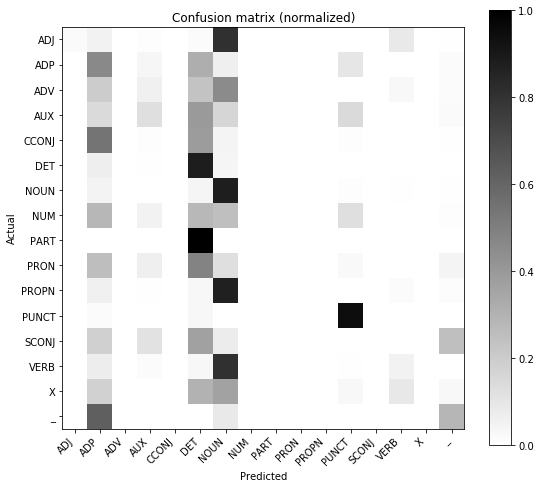

In [10]:
print(predict(["des", "nouvelles", "de"], charffnet))
print(predict(["une", "nouvelle", "robe"], charffnet))
# matrice of confusion
def vraipredis(testinput, testlabels, pos, net):
    vrais = [pos[i] for i in testlabels]
    predis = [pos[net.predict(np.array(inp, ndmin=2, dtype=np.float32))[0]] for inp in testinput]
    return vrais, predis
vrais, predis = vraipredis(w_te, p_te, pos, charffnet)
print("la f-mesure est",f1_score(vrais, predis, average='weighted'))
cmx = ConfusionMatrix(vrais, predis)
cmx.plot(normalized=True)

next we'll train with word2vec

In [2]:
#try with method_w2v
w_tr,p_tr,o_tr=toinput(w_tr,p_tr,dictionary_w2v)
print(w_tr.shape)
print(p_tr.shape)
w_te,p_te,o_te = toinput(w_te,p_te,dictionary_w2v)

print("nb de syntagmes sous forme vectorielle pour l'entrainement:",len(w_tr))
print("nb de syntagmes sous forme vectorielle pour le test:",len(w_te))


(51899, 300)
(51899,)
nb de syntagmes sous forme vectorielle pour l'entrainement: 51899
nb de syntagmes sous forme vectorielle pour le test: 10360


In [3]:
#creation of neural network
hidden_neurons = 2 * (len(pos) + 300)/3
print(300,hidden_neurons,len(pos))
charffnet = theanets.Classifier([300,
   {'size': int(hidden_neurons), 'activation': 'tanh'},
   len(pos)])



#training of network with w2v 
print('training on', len(w_tr),'samples. testing with',len(w_te),'test samples')
charffnet.train((w_tr, p_tr), (w_te,p_te), input_noise=0.3 , learning_rate=0.01)

#test by prediction of syntagme
#INPUT : a syntagme (list of 3 words, prediction of the pos of middle word), a trained network
#output : the POS of the middle word 
def predict(syntagme, net):
    """
    syntagme: syntagme of 3 words(list) to analyze the pos of the middle word
    net: theanets net to be used for prediction
    The function vectorizes the syntagme (=transformation into a vector using word2vec),
    predicts the pos
    """
    vec = []
    for unit in syntagme:
      vec += dictionary[unit]  
    if len(vec) == 0: return None
    input = np.array(vec,
                     ndmin=2,
                     dtype=np.float32)
    print(input.shape)
    result = net.predict(input)
    return pos[result[0]]
print(predict(["mange", "une", "pomme"], charffnet))
print(predict(["mange", "dans", "une"], charffnet))
print(predict(["je", "n'", "ai"], charffnet))


300 211.33333333333334 17
20190115 142419 theanets layer Input "in" (300,)
20190115 142419 theanets layer Feedforward "hid1" (211,) tanh from "in:out" (300,)
20190115 142419 theanets parameter "hid1.w" (300, 211)
20190115 142419 theanets parameter "hid1.b" (211,)
20190115 142419 theanets learnable parameters: 63511
20190115 142419 theanets layer Feedforward "out" (17,) softmax from "hid1:out" (211,)
20190115 142419 theanets parameter "out.w" (211, 17)
20190115 142419 theanets parameter "out.b" (17,)
20190115 142419 theanets learnable parameters: 3604
training on 51899 samples. testing with 10360 test samples
valid: 324 of 324 mini-batches from (10360, 300); (10360,)
train: 1622 of 1622 mini-batches from (51899, 300); (51899,)
20190115 142419 theanets building computation graph
20190115 142419 theanets using loss: 1.0 * CrossEntropy (output out:out)
20190115 142419 theanets regularizer: 0.3 * GaussianNoise(('in:out',))
downhill: compiling evaluation function
downhill: compiling RMSProp 

/home/dusty/.local/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


downhill: validation 0 loss=3.500273 err=3.500273 acc=0.036651 *
downhill: RMSProp 1 loss=1.178863 err=1.178863 acc=0.664416
downhill: RMSProp 2 loss=0.922519 err=0.922519 acc=0.732336
downhill: RMSProp 3 loss=0.846031 err=0.846031 acc=0.753590
downhill: RMSProp 4 loss=0.841201 err=0.841201 acc=0.755469
downhill: RMSProp 5 loss=0.821663 err=0.821663 acc=0.758804
downhill: RMSProp 6 loss=0.801949 err=0.801949 acc=0.765778
downhill: RMSProp 7 loss=0.802463 err=0.802463 acc=0.768204
downhill: RMSProp 8 loss=0.788431 err=0.788431 acc=0.770658
downhill: RMSProp 9 loss=0.790206 err=0.790206 acc=0.772937
downhill: RMSProp 10 loss=0.786989 err=0.786989 acc=0.771013
downhill: validation 1 loss=0.731431 err=0.731431 acc=0.781186 *
downhill: RMSProp 11 loss=0.770362 err=0.770362 acc=0.774590
downhill: RMSProp 12 loss=0.762138 err=0.762138 acc=0.780074
downhill: RMSProp 13 loss=0.759508 err=0.759508 acc=0.779492
downhill: RMSProp 14 loss=0.772716 err=0.772716 acc=0.778298
downhill: RMSProp 15 loss

downhill: RMSProp 122 loss=0.696939 err=0.696939 acc=0.803597
downhill: RMSProp 123 loss=0.701279 err=0.701279 acc=0.801171
downhill: RMSProp 124 loss=0.696379 err=0.696379 acc=0.804517
downhill: RMSProp 125 loss=0.687680 err=0.687680 acc=0.805350
downhill: RMSProp 126 loss=0.691482 err=0.691482 acc=0.803429
downhill: RMSProp 127 loss=0.684733 err=0.684733 acc=0.806462
downhill: RMSProp 128 loss=0.681798 err=0.681798 acc=0.807305
downhill: RMSProp 129 loss=0.711067 err=0.711067 acc=0.800241
downhill: RMSProp 130 loss=0.683787 err=0.683787 acc=0.804666
downhill: validation 13 loss=0.698432 err=0.698432 acc=0.801408
downhill: RMSProp 131 loss=0.692146 err=0.692146 acc=0.805102
downhill: RMSProp 132 loss=0.703847 err=0.703847 acc=0.801521
downhill: RMSProp 133 loss=0.688409 err=0.688409 acc=0.804276
downhill: RMSProp 134 loss=0.681921 err=0.681921 acc=0.806245
downhill: RMSProp 135 loss=0.688451 err=0.688451 acc=0.805017
downhill: RMSProp 136 loss=0.691866 err=0.691866 acc=0.804178
downhi

(1, 300)
NOUN
(1, 300)
ADJ
la f-mesure est 0.917268478790341


/home/dusty/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dusty/.local/lib/python3.5/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


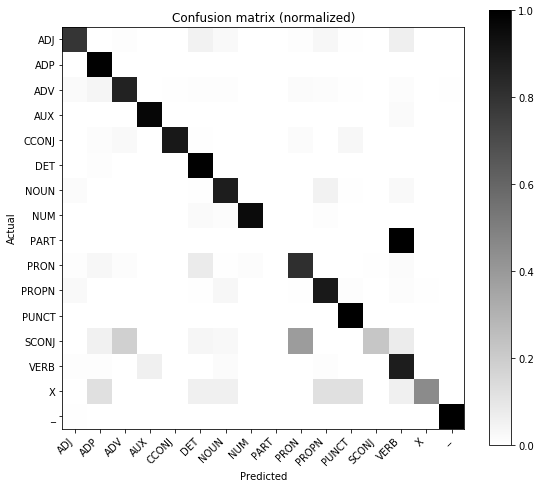

In [5]:
print(predict(["des", "nouvelles", "de"], charffnet))
print(predict(["une", "nouvelle", "robe"], charffnet))
# matrice of confusion
def vraipredis(testinput, testlabels, pos, net):
    vrais = [pos[i] for i in testlabels]
    predis = [pos[net.predict(np.array(inp, ndmin=2, dtype=np.float32))[0]] for inp in testinput]
    return vrais, predis
vrais, predis = vraipredis(w_te, p_te, pos, charffnet)
print("la f-mesure est",f1_score(vrais, predis, average='weighted'))
cmx = ConfusionMatrix(vrais, predis)
cmx.plot(normalized=True)

